<h1>Chord Representations</h1>
<br>
In this Notebook we are going to explore a different representation for the chords
<br>

In [8]:
import sys
# do this only once
sys.path.append('./src/audio-processing/')
sys.path.append('./src/data-processing/')

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#python input/output and regex
import re
import os
from pathlib import Path

#chord info
import pychord as pc

#signal processing libraries
from scipy.io import wavfile
from scipy import signal

#sklearn for normalization
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#tensorflow
import tensorflow as tf
from tensorflow import keras

#librosa
import librosa
import librosa.display

#import custom modules
import filters
import spectrograms
import audiofiles
from annotation_processing import chords_to_onehot

## Spectrograms

In [175]:
### get all audio files and create spectrogram for each track
audiofiles_path='Audiofiles/The Beatles'
n_fft=2048
nperseg=2048
Spectrograms, frequencies_num = spectrograms.create_spectrograms(n_fft, nperseg, audiofiles_path)

<h3>Loading Datasets</h3>

In [78]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Big-Dataset/The Beatles').glob('**/scratch/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

<h3>Chord Vocab</h3>

In [102]:
### Load all chords in a dictionary
Chords = []
Appearances = {}
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: 
                Chords.append(row['Chord'])
                Appearances[row['Chord']] = 0
            else: 
                Appearances[row['Chord']] += 1
                
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  407


## Dataset Annotations Transformation

<img src="images/label_representation.png" width="400" />

<caption><center> <b>Figure 3</b>: Labeling Representation.</center></caption>

In [132]:
ChordLib = {'C' : 0, 'C#': 1, 'Db' : 1, 'D' : 2, 'D#' : 3, 'Eb' : 3, 'E' : 4, 'F' : 5, 'F#' : 6, 'Gb' : 6, 'G' : 7, 'G#' : 8, 'Ab' : 9, 'A' : 10, 'A#' : 11, 'Bb' : 11, 'B' : 12, 'N' : 13}

In [162]:
def parse_chords(Chords, df):
    for chord in Chords:
        print('* Chord: ', chord)
        Mode = 'Major'
        bass = ''
        fourth_note = ''
        Unknown = False
        if chord.find(':') != -1:
            root, chord = chord.split(':')
            if chord[:3] == 'min':
                Mode = 'Minor'
                if chord != 'min':
                    if chord[3] == '7':
                        fourth_note = '7'
                        if chord[3:].find('/') != -1:
                            chord = chord[4:]
                            if chord in ['3','b3','5', 'b5', '7', 'b7']:
                                bass = chord
                            else:
                                Unknown = True
                        else:
                            bass = '0'
                    elif chord.find('/') != -1:
                        _, chord = chord.split('/')
                        if chord in ['3','b3','5', 'b5']:
                            bass = chord
                        else:
                            Unknown = True
                    else:
                        Unknown = True
                else:
                    bass = '0'
            elif chord[:3] == 'dim':
                Mode = 'Dim'
                if chord != 'dim':
                    fourth_note = chord[3]
                    if fourth_note == '/':
                        fourth_note = ''
                        bass = chord[4:]
                    else:
                        if chord[3:].find('/') != -1:
                            bass = chord[5:]
                        else:
                            bass = '0'
                else:
                    bass = '0'
            elif chord[:3] == 'aug':
                Mode = 'Aug'
                if chord != 'aug':
                    fourth_note = chord[3]
                    if fourth_note == '/':
                        fourth_note = ''
                        bass = chord[4:]
                    else:
                        if chord[3:].find('/') != -1:
                            bass = chord[5:]
                        else:
                            bass = '0'
                else:
                    bass = '0'
            elif chord[:3] == 'maj':
                Mode = 'Major'
                if chord != 'maj':
                    chord = chord[3:]
                    fourth_note = chord[0]
                    if fourth_note == '/':
                        fourth_note, bass = chord.split('/')
                    elif fourth_note == '(':
                        fourth_note = chord[1]
                        if fourth_note != '9':
                            Unknown = True
                        bass = '0'
                    else:
                        bass = '0'
                else:
                    bass = '0'
            elif chord[:4] == 'sus2':
                Mode = 'Sus2'
                bass = '0'
            elif chord[:4] == 'sus4':
                Mode = 'Sus4'
                bass = '0'
            elif chord[:4] == 'sus7':
                Mode = 'Sus7'
                bass = '0'
            elif chord[:4] == 'sus9':
                Mode = 'Sus9'
                bass = '0'
            elif chord[:3] == 'hdi':
                Unknown = True
            else:
                Mode = 'Major'
                fourth_note = chord[0]
                if fourth_note != '(':
                    if chord[1:].find('/') != -1:
                        if chord[1:].find('(') != -1:
                            bass = chord[2]
                        else:
                            bass = chord[2:]
                    else:
                        bass = '0'
                else:
                    Unknown = True

        elif chord.find('/') != -1:
            root, chord = chord.split('/')
            if chord in ['3','b3','5', 'b5']:
                bass = chord
            else:
                Unknown = True
        else:
            root = chord
            bass = '0'

        if not Unknown:
            print(root, bass, Mode, fourth_note)
            df['Root'].append(ChordLib[root])
            # inversions need work
            if bass[0] == 'b':
                bass = int(bass[1]) - 1
            elif bass[0] == '#':
                bass = int(bass[1]) + 1
            else:
                bass = int(bass)
            
            if root == 'N':
                df['Bass'].append(0)
            elif ChordLib[root] + int(bass) <= 12:
                df['Bass'].append(ChordLib[root] + int(bass))
            else:
                df['Bass'].append(12 - ChordLib[root] + int(bass))
                
            df['Unknown'].append(0)
            df['Major'].append(int(Mode == 'Major'))
            df['Minor'].append(int(Mode == 'Minor'))
            df['Diminished'].append(int(Mode == 'Diminished'))
            df['Augmented'].append(int(Mode == 'Augmented'))
            df['Major Seventh'].append(int((fourth_note == '7' or fourth_note == '9') and Mode == 'Major'))
            df['Minor Seventh'].append(int((fourth_note == '7' or fourth_note == '9') and Mode == 'Minor'))
            df['Major Sixth'].append(int(fourth_note == '6'))
            df['Ninth'].append(int(fourth_note == '9'))
        else:
            print ('Unknown')
            df['Root'].append(0)
            df['Bass'].append(0)
            df['Unknown'].append(1)
            df['Major'].append(0)
            df['Minor'].append(0)
            df['Diminished'].append(0)
            df['Augmented'].append(0)
            df['Major Seventh'].append(0)
            df['Minor Seventh'].append(0)
            df['Major Sixth'].append(0)
            df['Ninth'].append(0)
        print('-----')

In [163]:
df = pd.DataFrame(columns=('Root', 'Bass', 'Unknown', 'Major', 'Minor', 'Minor Seventh', 'Major Seventh', 'Augmented', 'Diminished', 'Ninth', 'Major Sixth'))
representations = {'Root' : [], 'Bass' : [], 'Unknown' : [], 'Major' : [], 'Minor' : [], 'Minor Seventh' : [], 'Major Seventh' : [], 'Augmented' : [], 'Diminished' : [], 'Ninth' : [], 'Major Sixth' : []}

In [164]:
parse_chords(Chords, representations)

* Chord:  N
N 0 Major 
-----
* Chord:  F:maj6
F 0 Major 6
-----
* Chord:  C
C 0 Major 
-----
* Chord:  G
G 0 Major 
-----
* Chord:  A:min
A 0 Minor 
-----
* Chord:  D:min7/4
Unknown
-----
* Chord:  F:maj/9
F 9 Major 
-----
* Chord:  C/7
Unknown
-----
* Chord:  C/5
C 5 Major 
-----
* Chord:  F
F 0 Major 
-----
* Chord:  Ab
Ab 0 Major 
-----
* Chord:  Bb
Bb 0 Major 
-----
* Chord:  Ab/7
Unknown
-----
* Chord:  Ab/b7
Unknown
-----
* Chord:  F:7
F 0 Major 7
-----
* Chord:  B
B 0 Major 
-----
* Chord:  A
A 0 Major 
-----
* Chord:  E
E 0 Major 
-----
* Chord:  E:7
E 0 Major 7
-----
* Chord:  D
D 0 Major 
-----
* Chord:  D:7
D 0 Major 7
-----
* Chord:  A/b7
Unknown
-----
* Chord:  F#:min7
F# 0 Minor 7
-----
* Chord:  D:maj(11)
Unknown
-----
* Chord:  D:maj(9)
D 0 Major 9
-----
* Chord:  C:maj(#11)
Unknown
-----
* Chord:  G/3
G 3 Major 
-----
* Chord:  D#:dim7
D# 0 Dim 7
-----
* Chord:  D/b7
Unknown
-----
* Chord:  G:min(9)/b3
G b3 Minor 
-----
* Chord:  D/5
D 5 Major 
-----
* Chord:  G#:(1)
U

**Convert the dictionary to dataframe**

In [172]:
df = pd.DataFrame(data=representations, index=Chords).rename_axis('Chord', axis = 1)
df

Chord,Root,Bass,Unknown,Major,Minor,Minor Seventh,Major Seventh,Augmented,Diminished,Ninth,Major Sixth
N,13,0,0,1,0,0,0,0,0,0,0
F:maj6,5,5,0,1,0,0,0,0,0,0,1
C,0,0,0,1,0,0,0,0,0,0,0
G,7,7,0,1,0,0,0,0,0,0,0
A:min,10,10,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
G:maj6(9),7,7,0,1,0,0,0,0,0,0,1
G:dim7,7,7,0,0,0,0,0,0,0,0,0
B:aug/3,12,3,0,0,0,0,0,0,0,0,0
D:maj/2,2,4,0,1,0,0,0,0,0,0,0


Now this is a dictionary for every chord<br>
I'm going to index every chord with its timestep just liek before, but instead of a one hot of size 407, we will have the above representation<br>

## Preprocessing

In [177]:
### Annotations
Artist='The Beatles'
Timeseries=Spectrograms
chords2vec = {}
for album in Chordlab[Artist].keys():
    chords2vec[album] = {}
    for track_no in Chordlab[Artist][album].keys():
        times = Timeseries[Artist][album][track_no]['times']
        df_rows = Chordlab[Artist][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab[Artist][album][track_no])
        vector = np.empty((11,))
        row = next(df_rows)
        for timestamp in times:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                index += 1
                row = next(df_rows)
            vector = np.column_stack((vector, df.loc[row[3]]))
        chords2vec[album][track_no] = vector
        print(album, ': track ', track_no, ' completed')

# Take care fo the one extra row in the beginning of the array
for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        chords2vec[album][track_no] = np.delete(chords2vec[album][track_no], 0, 1)

09_-_Magical_Mystery_Tour : track  07  completed
09_-_Magical_Mystery_Tour : track  06  completed
09_-_Magical_Mystery_Tour : track  04  completed
09_-_Magical_Mystery_Tour : track  01  completed
09_-_Magical_Mystery_Tour : track  03  completed
09_-_Magical_Mystery_Tour : track  08  completed
09_-_Magical_Mystery_Tour : track  02  completed
09_-_Magical_Mystery_Tour : track  09  completed
09_-_Magical_Mystery_Tour : track  11  completed
09_-_Magical_Mystery_Tour : track  10  completed
09_-_Magical_Mystery_Tour : track  05  completed
12_-_Let_It_Be : track  09  completed
12_-_Let_It_Be : track  11  completed
12_-_Let_It_Be : track  04  completed
12_-_Let_It_Be : track  01  completed
12_-_Let_It_Be : track  10  completed
12_-_Let_It_Be : track  03  completed
12_-_Let_It_Be : track  08  completed
12_-_Let_It_Be : track  06  completed
12_-_Let_It_Be : track  12  completed
12_-_Let_It_Be : track  05  completed
12_-_Let_It_Be : track  07  completed
12_-_Let_It_Be : track  02  completed
04_-_

<h4>Constructing numpy arrays</h4>

In [178]:
chunk_size = 500

In [179]:
x_train = np.zeros((1,chunk_size,frequencies_num)) #num of frequencies
y_train = np.zeros((1,chunk_size,11))
x_test = np.zeros((1,chunk_size,frequencies_num)) #num of frequencies
y_test = np.zeros((1,chunk_size,11))

#test track
test_track_no = '01'
album_test_track = '09_-_Magical_Mystery_Tour'

for album in chords2vec.keys():
    for track_no in chords2vec[album].keys():
        timestep = 0
        # size of the current track
        chunks = chords2vec[album][track_no].T.shape[0]
        # track frequencies
        spectrogram = Spectrograms['The Beatles'][album][track_no]['powerSpectrum'].T
        # track annotations
        annotations = chords2vec[album][track_no].T
        # slice and stack train-test data
        if track_no != test_track_no or album != album_test_track:
            # train tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(spectrogram[timestep:timestep+chunk_size,:], (1, chunk_size, frequencies_num)) #num of frequencies
                    x_train = np.append(x_train, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 11))
                    y_train = np.append(y_train, batch_y, axis = 0)
                else:
                    batch_x = spectrogram[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,frequencies_num))))
                        batch_y = np.vstack((batch_y, df.loc['N']))
                    x_train = np.append(x_train, np.array([batch_x]), axis = 0)
                    y_train = np.append(y_train, np.array([batch_y]), axis = 0)
                timestep += chunk_size
        else:
            # test tracks
            while timestep < chunks :
                if (chunks - timestep) > chunk_size:
                    batch_x = np.resize(spectrogram[timestep:timestep+chunk_size,:], (1, chunk_size, frequencies_num)) #num of frequencies
                    x_test = np.append(x_test, batch_x, axis = 0)
                    batch_y = np.resize(annotations[timestep:timestep+chunk_size,:], (1, chunk_size, 11))
                    y_test = np.append(y_test, batch_y, axis = 0)
                else:
                    batch_x = spectrogram[timestep:,:]
                    batch_y = annotations[timestep:,:]
                    for step in range (0, chunk_size + timestep - chunks):
                        batch_x = np.vstack((batch_x, np.zeros((1,frequencies_num))))
                        batch_y = np.vstack((batch_y, df.loc['N']))
                    x_test = np.append(x_test, np.array([batch_x]), axis = 0)
                    y_test = np.append(y_test, np.array([batch_y]), axis = 0)
                # augment timesteps
                timestep += chunk_size

print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1520, 500, 1025) (1520, 500, 11) (10, 500, 1025) (10, 500, 11)


Delete the first row from every array because of the append, which left it all zeros.

In [180]:
x_train = np.delete(x_train,0,0)
y_train = np.delete(y_train,0,0)
x_test = np.delete(x_test,0,0)
y_test = np.delete(y_test,0,0)

In [181]:
print(x_train.shape)
print(y_train.shape)
print (x_test.shape)
print (y_test.shape)

(1519, 500, 1025)
(1519, 500, 11)
(9, 500, 1025)
(9, 500, 11)


In [18]:
x_train2 = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train2 = np.reshape(y_train,(y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
x_test2 = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
y_test2 = np.reshape(y_test,(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

## Neural Network

In [182]:
from tensorflow.keras.layers import Input, TimeDistributed, Embedding, LSTM, Bidirectional, Dropout, Dense, GRU, concatenate, Conv1D, Conv2D, Flatten,MaxPooling1D, LocallyConnected1D, Activation, GaussianNoise, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform

#### BLSTM_2Layer

In [219]:
def BLSTM_2Layer(chords_num, frequencies_num, timesteps, batch_size):
    
    main_input = Input(shape=(timesteps,frequencies_num), name='main_input')
    
    #BLSTM
    x = Bidirectional(LSTM(units = 64, 
                           batch_input_shape = (batch_size, timesteps, frequencies_num),
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences = True))(main_input)
    x = Dropout(0.5)(x)
    
    #BLSTM on the concatanted output
    x = Bidirectional(LSTM(units = 64,
                           kernel_initializer = 'glorot_uniform',
                           bias_initializer = RandomNormal(),
                           recurrent_activation='sigmoid',
                           recurrent_regularizer='l2',
                           recurrent_dropout = 0.25,
                           return_sequences=True))(x)
    x = Dropout(0.5)(x)
    
    #Dense for classification
    main_output = Dense(chords_num, kernel_initializer='normal')(x)
    #model
    model = Model(inputs=[main_input], outputs=[main_output])

    return model

#### Summary

In [220]:
batch_size = 32

In [221]:
chroma_model = BLSTM_2Layer(11, frequencies_num, chunk_size, batch_size)

chroma_model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.mean_squared_error,
              metrics=['accuracy'])

chroma_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 500, 1025)]       0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 500, 128)          558080    
_________________________________________________________________
dropout_12 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 500, 128)          98816     
_________________________________________________________________
dropout_13 (Dropout)         (None, 500, 128)          0         
_________________________________________________________________
dense_7 (Dense)              (None, 500, 11)           1419      
Total params: 658,315
Trainable params: 658,315
Non-trainable params: 0
_____________________________________________________

**Fit**

In [222]:
epochs = 10

# train
callback_history = chroma_model.fit(x_train, y_train, epochs=epochs,
          validation_data=(x_test, y_test), batch_size=batch_size, verbose=1)

Train on 1519 samples, validate on 9 samples
Epoch 1/10
1519/1519 [==============================] - 29s 19ms/sample - loss: 6.6575 - accuracy: 0.4355 - val_loss: 3.6120 - val_accuracy: 0.8682
Epoch 2/10
1519/1519 [==============================] - 26s 17ms/sample - loss: 3.7763 - accuracy: 0.7648 - val_loss: 2.4636 - val_accuracy: 0.8620
Epoch 3/10
1519/1519 [==============================] - 27s 18ms/sample - loss: 3.0266 - accuracy: 0.6308 - val_loss: 1.7091 - val_accuracy: 0.6584
Epoch 4/10
1519/1519 [==============================] - 27s 17ms/sample - loss: 2.6339 - accuracy: 0.5721 - val_loss: 1.5134 - val_accuracy: 0.6971
Epoch 5/10
1519/1519 [==============================] - 26s 17ms/sample - loss: 2.4521 - accuracy: 0.5469 - val_loss: 1.2286 - val_accuracy: 0.6722
Epoch 6/10
1519/1519 [==============================] - 26s 17ms/sample - loss: 2.3402 - accuracy: 0.5549 - val_loss: 1.1525 - val_accuracy: 0.4911
Epoch 7/10
1519/1519 [==============================] - 26s 17ms/sa

In [223]:
# evaluate on test set
loss, accuracy = chroma_model.evaluate([x_test], y_test, verbose=0)
print("Loss: \t\t% 3.3f \nAccuracy: \t% 3.2f %%" %(loss, 100*accuracy))

Loss: 		 1.035 
Accuracy: 	 27.62 %


**Predictions -> Chords**

In [224]:
predictions = chroma_model.predict(x_test, batch_size=batch_size, use_multiprocessing=True)

In [233]:
estimated_chord_list = []
real_chord_list = Chordlab['The Beatles'][album_test_track][test_track_no]

for batch_chords in predictions:
    for chord in batch_chords:
        pred_chord = [int(round(chord[0]*1000 % 13)), int(round(chord[1]*1000 % 13))]
        for scalar in chord[2:]:
            pred_chord.append(int(scalar > 0.12))
        estimated_chord_list.append(pred_chord)
        
df_predictions = pd.DataFrame({'Estimated Chords' : estimated_chord_list})
display(df_predictions['Estimated Chords'][250:270])

250      [5, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
251      [4, 9, 0, 1, 1, 0, 0, 0, 0, 0, 0]
252     [10, 9, 0, 1, 1, 0, 0, 0, 0, 0, 0]
253      [2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
254     [2, 10, 0, 1, 1, 0, 0, 0, 0, 0, 0]
255      [7, 8, 0, 1, 1, 0, 0, 0, 0, 0, 0]
256     [3, 12, 0, 1, 1, 0, 0, 0, 0, 0, 0]
257     [3, 11, 0, 1, 1, 0, 0, 0, 0, 0, 0]
258      [6, 5, 0, 1, 1, 0, 0, 0, 0, 0, 0]
259      [2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
260      [4, 6, 0, 1, 1, 0, 0, 0, 0, 0, 0]
261    [10, 11, 0, 1, 1, 0, 0, 0, 0, 0, 0]
262      [6, 8, 0, 1, 1, 0, 0, 0, 0, 0, 0]
263    [11, 10, 0, 1, 1, 0, 0, 0, 0, 0, 0]
264     [1, 13, 0, 1, 1, 0, 0, 0, 0, 0, 0]
265     [4, 11, 0, 1, 1, 0, 0, 0, 0, 0, 0]
266      [1, 5, 0, 1, 1, 0, 0, 0, 0, 0, 0]
267     [1, 10, 0, 1, 1, 0, 0, 0, 0, 0, 0]
268      [8, 9, 0, 1, 1, 0, 0, 0, 0, 0, 0]
269     [12, 4, 0, 1, 1, 0, 0, 0, 0, 0, 0]
Name: Estimated Chords, dtype: object

### Plot Efficiency of model

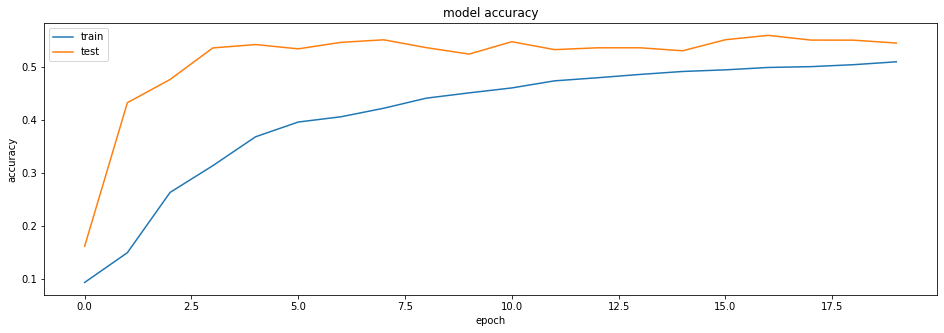

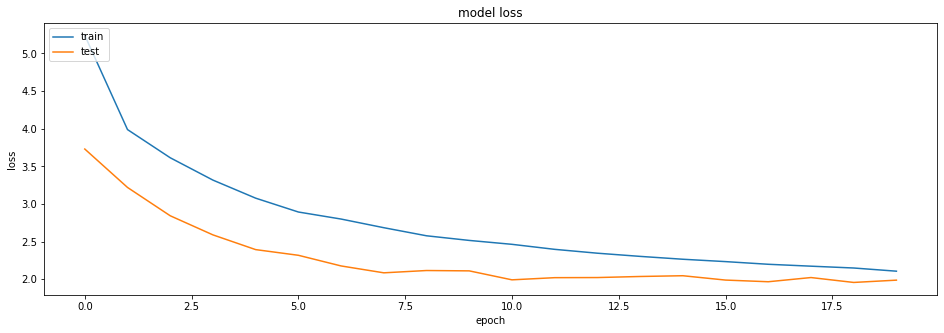

In [87]:
plt.figure(figsize=(16,5))
# summarize history for accuracy
plt.plot(callback_history.history['accuracy'])
plt.plot(callback_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure(figsize=(16,5))
# summarize history for loss
plt.plot(callback_history.history['loss'])
plt.plot(callback_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Post Processing

In [234]:
min_frames = 5

#pass through data
previous_seen_chord = df_predictions['Estimated Chords'][0]
previous_chord = df_predictions['Estimated Chords'][0]
appearances = 1
count = 1
for chord in df_predictions['Estimated Chords'][1:]:
    if previous_chord != chord:
        previous_chord = chord
        if appearances <= min_frames:
            for i in range(count-appearances, count):
                df_predictions['Estimated Chords'][i] = previous_seen_chord
        else:
            previous_seen_chord = chord
        #new chord -> appearances = 1
        appearances = 1
    else:
        appearances += 1
                
    count += 1

In [235]:
#segments of audio data
segments = Spectrograms['The Beatles'][album_test_track][test_track_no]['times']

#annotation data
Annotation = {'Starts' : [], 'Ends' : [], 'Chord' : []}

#first chord
Annotation['Chord'].append(df_predictions['Estimated Chords'][0])
Annotation['Starts'].append(0.0)

#rest of the predictions
step = 1
current_chord = df_predictions['Estimated Chords'][0]
for time in segments:
    chord = df_predictions['Estimated Chords'][step]
    if current_chord != chord:
        Annotation['Ends'].append(time)
        Annotation['Chord'].append(chord)
        Annotation['Starts'].append(time)
        current_chord = chord
    step+=1
Annotation['Ends'].append(time)

In [236]:
Annotation_df = pd.DataFrame(data=Annotation)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(Annotation_df)

,Starts,Ends,Chord
0,0.000000,168.983220,"[0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,168.983220,169.227029,"[9, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
2,169.227029,169.511474,"[8, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,169.511474,169.755283,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,169.755283,170.242902,"[6, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [237]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(Chordlab['The Beatles'][album_test_track][test_track_no])

,Starts,Ends,Chord
0,0.035468,1.146092,N
1,1.146092,2.620542,D
2,2.620542,4.056693,A
3,4.056693,9.823253,E
4,9.823253,12.760743,E
5,12.760743,14.177241,G
6,14.177241,15.628569,A
7,15.628569,18.519616,E
8,18.519616,19.947724,G
9,19.947724,21.367110,A
